In [1]:
%load_ext autoreload
%autoreload 2

In [68]:
import os, h5py
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
from tqdm import tqdm

from msfm.utils import files, filenames, cross_statistics, observation

In [19]:
msfm_conf = files.load_config("/global/homes/a/athomsen/multiprobe-simulation-forward-model/configs/v15/extended.yaml")

# CosmoGrid

In [92]:
# indices, names = cross_statistics.get_cross_bin_indices(with_lensing=True, with_clustering=False, with_cross_z=False)
indices, names = cross_statistics.get_cross_bin_indices(with_lensing=True, with_clustering=False, with_cross_z=True)

obs_dir = "/pscratch/sd/a/athomsen/v11desy3/v15/extended/obs"
obs_files = ["cosmo_114996_obs_maps_Aia=-1.h5", "cosmo_114996_obs_maps_Aia=0.h5", "cosmo_114996_obs_maps_Aia=1.h5"]
obs_labels = ["Aia=-1", "Aia=0", "Aia=1"]

### raw

[Text(0.5, 0, '$\\ell$'), (0.0, 1500.0)]

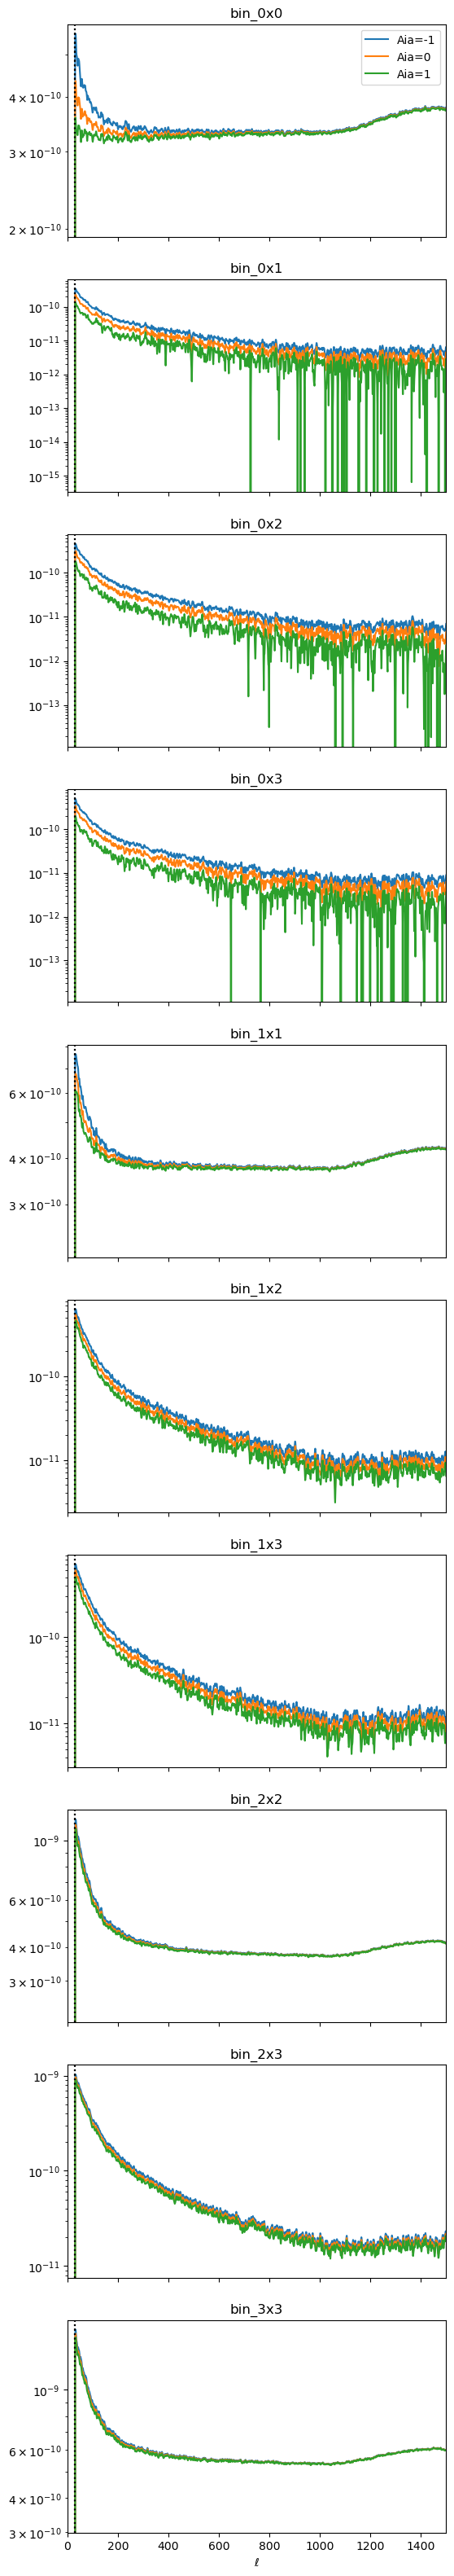

In [93]:
nrows = len(indices)
fig, ax = plt.subplots(nrows=nrows, figsize=(6, 4*nrows), sharex=True)

for i, obs_file in enumerate(obs_files):
    with h5py.File(os.path.join(obs_dir, obs_file), "r") as f:
        cls = f["obs/cls_raw"][:]

    cls = cls[...,indices]
    cls = np.mean(cls, axis=0)
    for j in range(nrows):
        cl = cls[:,j]
    
        ax[j].plot(cl, label=obs_labels[i])

        ax[j].axvline(30, color="k", linestyle=":")
        ax[j].set(xscale="linear", yscale="log", title=names[j])

ax[0].legend()
ax[-1].set(xlabel=r"$\ell$", xlim=(0, 1500))

# Buzzard

In [89]:
buzzard_indices = list(range(0, 16))
buzzard_indices.remove(1)

# buzzard_indices = [0]
buzzard_cls = []
for i in tqdm(buzzard_indices):
    out_label = f"mocks/pred/Buzzard_{i}"
    lensing_file = f"/pscratch/sd/j/jbucko/DESY3/mock_observations/lensing/buzzard_flock/{i}/DESY3_mock_observation_buzzard_flock_v14_shear_noise+WL_iseed_42_varied.h5"

    with h5py.File(lensing_file, "r") as f_in:
        gamma1 = []
        gamma2 = []
        for j in range(1,5):
            gamma1.append(f_in[f"metacal/raw_gamma1_bin{j}"])
            gamma2.append(f_in[f"metacal/raw_gamma2_bin{j}"])
        gamma1 = np.stack(gamma1, axis=-1)
        gamma2 = np.stack(gamma2, axis=-1)
        
        wl_map = np.stack([gamma1, gamma2], axis=-1)
    
    obs_map, obs_cls, _ = observation.forward_model_observation_map(
        wl_gamma_map=wl_map,
        gc_count_map=np.zeros(wl_map.shape[:2]),
        conf=msfm_conf,
        apply_norm=False,
        with_padding=True,
        nest_in=False,
    )

    buzzard_cls.append(obs_cls)
buzzard_cls = np.stack(buzzard_cls)

100%|██████████| 15/15 [01:34<00:00,  6.31s/it]


In [96]:
mean_buzzard_cls = np.mean(buzzard_cls, axis=0)
mean_buzzard_cls = mean_buzzard_cls[:, indices]

# plot

[Text(0.5, 0, '$\\ell$'), (0.0, 1500.0)]

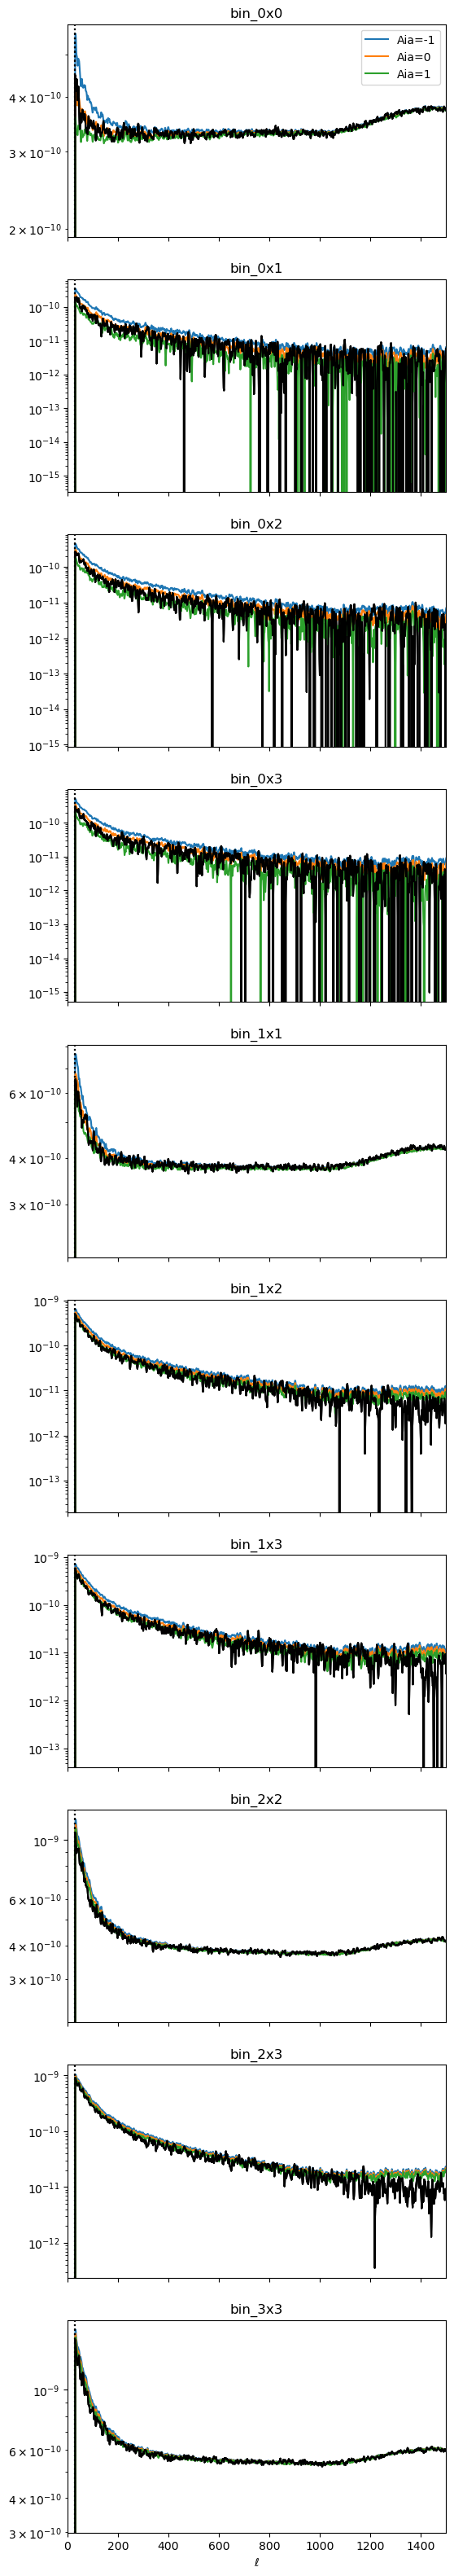

In [97]:
nrows = len(indices)
fig, ax = plt.subplots(nrows=nrows, figsize=(6, 4*nrows), sharex=True)

for i, obs_file in enumerate(obs_files):
    with h5py.File(os.path.join(obs_dir, obs_file), "r") as f:
        cls = f["obs/cls_raw"][:]

    cls = cls[...,indices]
    cls = np.mean(cls, axis=0)
    for j in range(nrows):
        cl = cls[:,j]
        buzzard_cl = mean_buzzard_cls[:,j]
    
        ax[j].plot(cl, label=obs_labels[i])

        ax[j].plot(buzzard_cl, color="k", linestyle="-")

        ax[j].axvline(30, color="k", linestyle=":")
        ax[j].set(xscale="linear", yscale="log", title=names[j])

ax[0].legend()
ax[-1].set(xlabel=r"$\ell$", xlim=(0, 1500))

# trash